In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\jkmfi\Documents\Quant_nifty_project\data\clean\nifty_features_5min.csv")

In [4]:
df = df.copy()

# Convert date
if 'TradeDate' in df.columns:
    df['TradeDate'] = pd.to_datetime(df['TradeDate'])
    df['Hour'] = df['TradeDate'].dt.hour
    df['DayOfWeek'] = df['TradeDate'].dt.dayofweek

# Sort by time (VERY IMPORTANT)
df.sort_values('TradeDate', inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
if 'EMA_5' not in df.columns or 'EMA_15' not in df.columns:
    raise ValueError("EMA_5 or EMA_15 columns are missing!")

df['Position'] = 0
df.loc[df['EMA_5'] > df['EMA_15'], 'Position'] = 1
df.loc[df['EMA_5'] < df['EMA_15'], 'Position'] = -1

print(df['Position'].value_counts())

 1    155
-1     94
 0      1
Name: Position, dtype: int64


In [6]:
df['Return'] = df['Close_spot'].pct_change()
df['Strategy_Return'] = df['Position'].shift(1) * df['Return']
df[['Return','Strategy_Return']] = df[['Return','Strategy_Return']].fillna(0)

In [7]:
required_cols = ['Close_spot', 'Position']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

In [8]:
df['Trade_Duration'] = 0
duration = 0
prev_pos = 0
for i in range(len(df)):
    curr_pos = df.iloc[i]['Position']
    if curr_pos != 0 and curr_pos == prev_pos:
        duration += 1
    elif curr_pos != 0 and curr_pos != prev_pos:
        duration = 1
    else:
        duration = 0
    df.iloc[i, df.columns.get_loc('Trade_Duration')] = duration
    prev_pos = curr_pos

In [11]:
# Keep only actual trades (ignore flat position)
trades = df[df['Position'] != 0].copy()

# Define outliers based on trade duration (top 5%)
duration_threshold = trades['Trade_Duration'].quantile(0.95)

normal_trades = trades[trades['Trade_Duration'] <= duration_threshold]
outliers = trades[trades['Trade_Duration'] > duration_threshold]

print("Normal trades:", len(normal_trades))
print("Outlier trades:", len(outliers))

Normal trades: 238
Outlier trades: 11


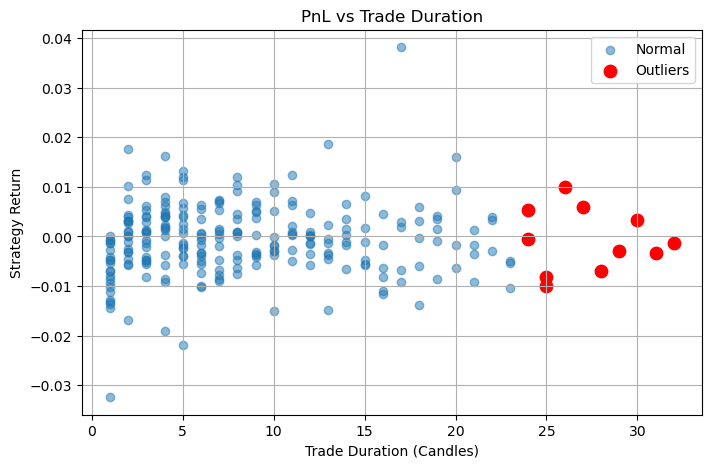

In [12]:
plt.figure(figsize=(8,5))

plt.scatter(
    normal_trades['Trade_Duration'],
    normal_trades['Strategy_Return'],
    alpha=0.5,
    label='Normal'
)

if len(outliers) > 0:
    plt.scatter(
        outliers['Trade_Duration'],
        outliers['Strategy_Return'],
        color='red',
        s=80,
        label='Outliers'
    )

plt.xlabel("Trade Duration (Candles)")
plt.ylabel("Strategy Return")
plt.title("PnL vs Trade Duration")
plt.legend()
plt.grid(True)
plt.show()

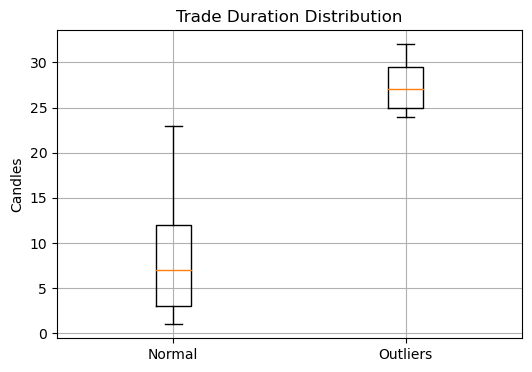

In [13]:
plt.figure(figsize=(6,4))

plt.boxplot(
    [
        normal_trades['Trade_Duration'],
        outliers['Trade_Duration'] if len(outliers) > 0 else [0]
    ],
    labels=['Normal', 'Outliers']
)

plt.title("Trade Duration Distribution")
plt.ylabel("Candles")
plt.grid(True)
plt.show()


In [15]:
# Select only profitable trade bars
profitable_trades = df[df['Strategy_Return'] > 0].copy()

print("Profitable bars:", len(profitable_trades))

Profitable bars: 116


### HEATMAP

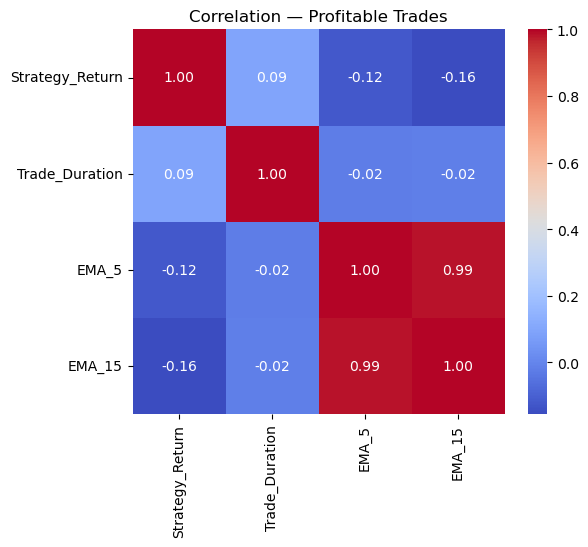

In [16]:
corr_features = [
    'Strategy_Return',
    'Trade_Duration',
    'EMA_5',
    'EMA_15',
    'ATR'
]

corr_features = [c for c in corr_features if c in profitable_trades.columns]

plt.figure(figsize=(6,5))
sns.heatmap(
    profitable_trades[corr_features].corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)
plt.title("Correlation — Profitable Trades")
plt.show()